# Vocabulary Builder

This notebook will:
1. Clean the CSV file of Los Miserables
2. Standardize the text (lowercase, no whitespace, no punctuation, no accents)
3. Create a vocabulary with word frequencies
4. Store the vocabulary on disk in parquet format
5. Compute and display statistics

In [13]:
# Import required libraries
import pandas as pd
import re
import string
from collections import Counter
from unidecode import unidecode
import os
import matplotlib.pyplot as plt

# Create output directories if they don't exist
os.makedirs('../fig', exist_ok=True)
os.makedirs('../report', exist_ok=True)

## 1. Load the CSV data

In [14]:
# File paths
csv_path = '../dat/Los-miserables.csv'
vocab_path = '../dat/Los-miserables-vocabulary.parquet'
stats_path = '../report/statistics.txt'

# Read the CSV file containing the text
df = pd.read_csv(csv_path)

# Display first few rows to understand the structure
print(f"CSV contains {len(df)} rows and {len(df.columns)} columns")
df.head()

CSV contains 305 rows and 2 columns


,page_number,text
0,1,NaN
1,2,"2 Los miserables I Hugo, Victor Novela Se reco..."
2,3,3 PRIMERA PARTE Fantine
3,4,4 LIBRO PRIMERO Un justo
4,5,"5 I El señor Myriel En 1815, monseñor Charles-..."


## 2. Standardize Text

We'll define a function to standardize text by:
- Converting to lowercase
- Removing punctuation
- Removing accents
- Removing extra whitespace

In [15]:
def standardize_text(text):
    """
    Standardize text by:
    - Converting to lowercase
    - Removing punctuation
    - Removing accents
    - Removing extra whitespace
    """
    # Convert to lowercase
    text = text.lower()
    
    # Remove accents
    text = unidecode(text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

## 3. Process Text and Create Vocabulary

In [16]:
print("Combining all text...")
# Combine all text into a single string
all_text = ' '.join(df['text'].astype(str).tolist())

print("Standardizing text...")
# Standardize text
standardized_text = standardize_text(all_text)

# Display a sample of the standardized text
print("\nSample of standardized text:")
print(standardized_text[:500], "...")

Combining all text...
Standardizing text...

Sample of standardized text:
nan los miserables i hugo victor novela se reconocen los derechos morales de hugo victor obra de dominio publico distribucion gratuita prohibida su venta y distribucion en medios ajenos a la fundacion carlos slim fundacion carlos slim lago zurich plaza carso ii piso col ampliacion granada c p ciudad de mexico mexico contactopruebatorg primera parte fantine libro primero un justo i el senor myriel en monsenor charlesfrancoisbienvenu myriel era obispo de digne era un anciano de cerca de setenta y  ...


In [17]:
print("Creating vocabulary...")
# Split into words and count frequencies
words = standardized_text.split()

# Count total words in original text
total_words = len(words)

# Create vocabulary with word frequencies
word_counts = Counter(words)

# Create DataFrame for vocabulary
vocab_df = pd.DataFrame({
    'word': list(word_counts.keys()),
    'frequency': list(word_counts.values())
}).sort_values(by='frequency', ascending=False)

# Display vocabulary sample
print(f"Vocabulary contains {len(vocab_df)} unique words")
vocab_df.head(10)

Creating vocabulary...
Vocabulary contains 13106 unique words


,word,frequency
11,de,5325
25,la,3918
76,que,3818
50,el,3394
20,y,3123
21,en,2836
24,a,2489
7,se,1681
48,un,1601
69,no,1499


## 4. Store Vocabulary in Parquet Format

In [18]:
# Store vocabulary in parquet format
vocab_df.to_parquet(vocab_path, index=False)
print(f"Vocabulary saved to {vocab_path}")

# Verify file was created
if os.path.exists(vocab_path):
    file_size = os.path.getsize(vocab_path) / 1024  # Size in KB
    print(f"File size: {file_size:.2f} KB")
else:
    print("Failed to create parquet file")

Vocabulary saved to ../dat/Los-miserables-vocabulary.parquet
File size: 121.12 KB


## 5. Compute and Display Statistics

In [19]:
# Calculate statistics
unique_words = len(word_counts)
most_frequent = vocab_df.head(100)
least_frequent = vocab_df.tail(100)

# Print summary statistics
print("\n--- Summary Statistics ---")
print(f"Total words in original text: {total_words}")
print(f"Number of unique words in vocabulary: {unique_words}")
print(f"Average frequency: {total_words / unique_words:.2f} occurrences per word")


--- Summary Statistics ---
Total words in original text: 109264
Number of unique words in vocabulary: 13106
Average frequency: 8.34 occurrences per word


### Word Frequency Distribution Visualization

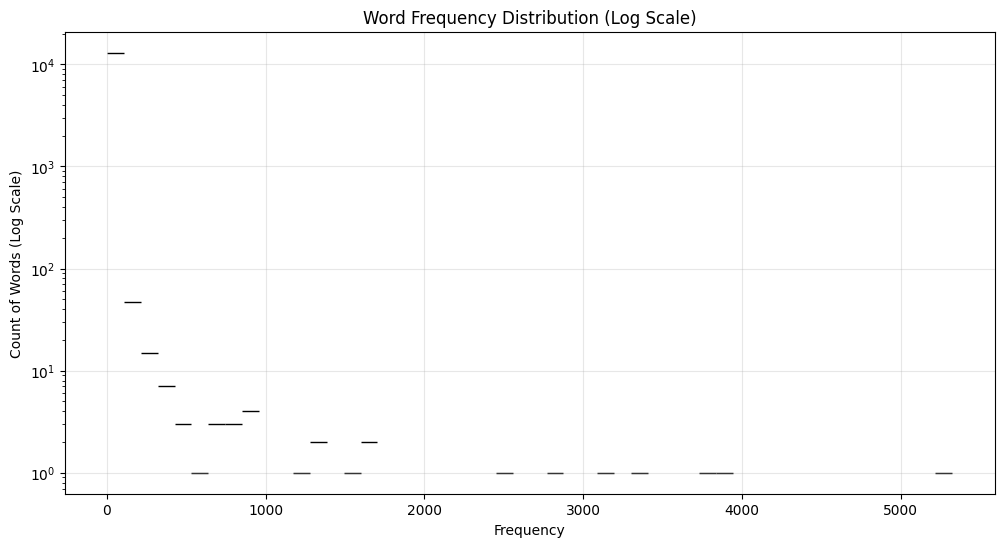

In [20]:
# Create a distribution plot for word frequencies
plt.figure(figsize=(12, 6))
sns.histplot(vocab_df['frequency'], bins=50, log_scale=(False, True))
plt.title('Word Frequency Distribution (Log Scale)')
plt.xlabel('Frequency')
plt.ylabel('Count of Words (Log Scale)')
plt.grid(True, alpha=0.3)
plt.savefig('../fig/word_frequency_distribution.png')
plt.show()

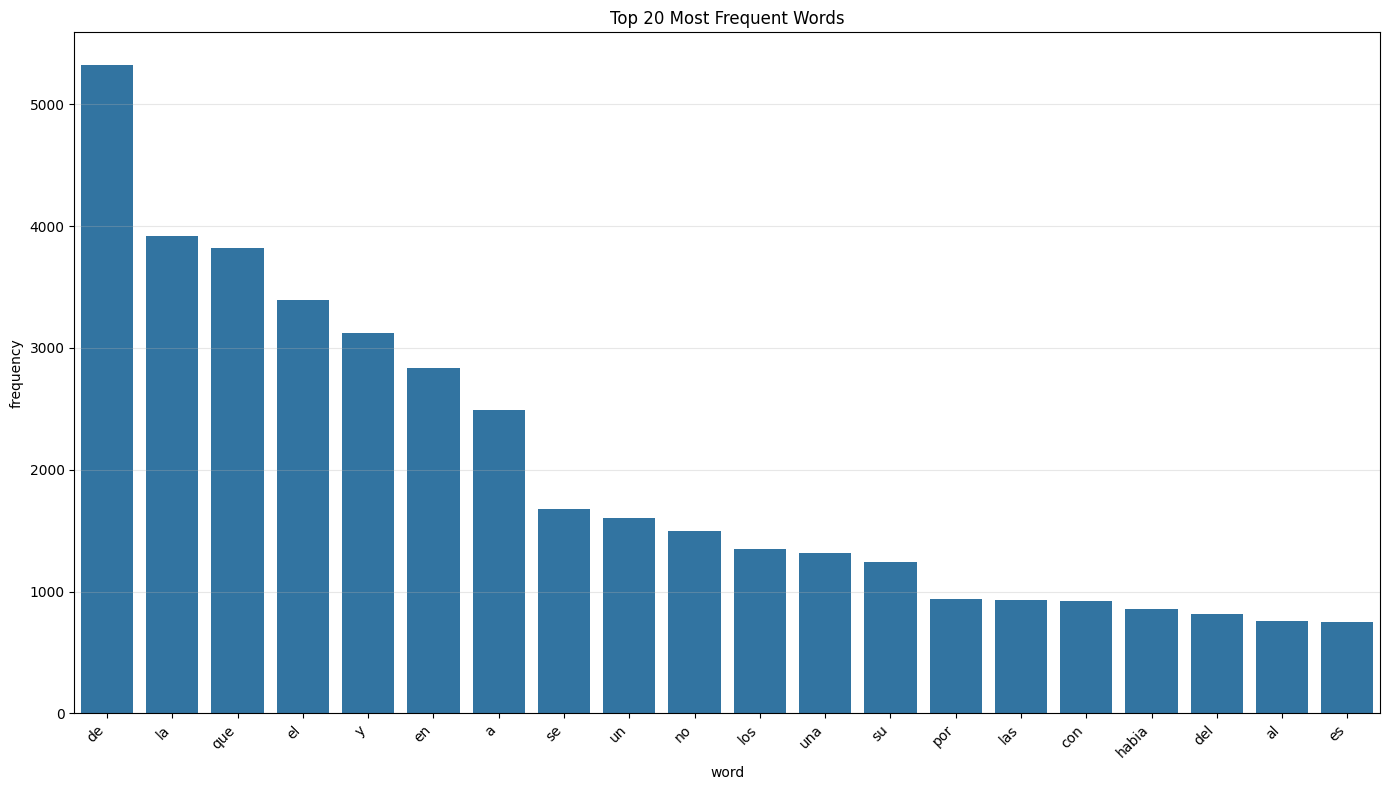

In [21]:
# Top 20 most frequent words visualization
plt.figure(figsize=(14, 8))
top20 = vocab_df.head(20)
sns.barplot(x='word', y='frequency', data=top20)
plt.title('Top 20 Most Frequent Words')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('../fig/top20_words.png')
plt.show()

## 6. Most Frequent Words (Top 100)

In [22]:
# Display most frequent words
print("\n--- 100 Most Frequent Words ---")
most_frequent


--- 100 Most Frequent Words ---


,word,frequency
11,de,5325
25,la,3918
76,que,3818
50,el,3394
20,y,3123
...,...,...
663,voz,111
171,alli,107
452,ojos,107
191,aun,105


## 7. Least Frequent Words (Bottom 100)

In [23]:
# Display least frequent words
print("\n--- 100 Least Frequent Words ---")
least_frequent


--- 100 Least Frequent Words ---


,word,frequency
12973,respondedme,1
12972,dices,1
12971,irte,1
12970,pides,1
13001,emocionantes,1
...,...,...
13095,devuelta,1
13094,alejaba,1
13093,brumas,1
13092,marchando,1


## 8. Save Statistics to File

In [24]:
# Save statistics to a text file
with open(stats_path, 'w', encoding='utf-8') as f:
    f.write("=== Los Miserables Text Analysis ===\n\n")
    f.write(f"Total words in original text: {total_words}\n")
    f.write(f"Number of unique words in vocabulary: {unique_words}\n")
    f.write(f"Average frequency: {total_words / unique_words:.2f} occurrences per word\n\n")
    
    f.write("=== 100 Most Frequent Words ===\n\n")
    f.write(most_frequent.to_string(index=False) + "\n\n")
    
    f.write("=== 100 Least Frequent Words ===\n\n")
    f.write(least_frequent.to_string(index=False) + "\n\n")

print(f"\nStatistics saved to {stats_path}")


Statistics saved to ../report/statistics.txt
